In [96]:
import pandas as pd
import geopandas as gpd
from geopy.geocoders import OpenCage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn import linear_model
from shapely.geometry import Point,LineString

In [29]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


In [2]:
#we'll use this later for plotting
from adjustText import adjust_text

In [3]:
os.getcwd()

'C:\\Users\\olubl\\OneDrive\\14th grade\\PDEW_Predict'

In [3]:
#let's read in the PDEW dataframe. This is already filtered to only the 3rd quarter of 2024 using an sql query in the dot website.
all_pdew = pd.read_csv('C:\\Users\\olubl\\OneDrive\\14th grade\\PDEW_Predict\\data\\pdew_3q_2024.csv')
all_pdew = all_pdew[['Year','quarter','city1','city2','nsmiles','passengers','fare','carrier_lg']]

In [4]:
all_pdew.head()

,Year,quarter,city1,city2,nsmiles,passengers,fare,carrier_lg
0,2024,3,"Allentown/Bethlehem/Easton, PA","Dallas/Fort Worth, TX",1307,18,367.69,AA
1,2024,3,"Allentown/Bethlehem/Easton, PA","Denver, CO",1539,89,138.60,G4
2,2024,3,"Allentown/Bethlehem/Easton, PA","Atlanta, GA (Metropolitan Area)",692,107,319.69,DL
3,2024,3,"Allentown/Bethlehem/Easton, PA","Austin, TX",1441,13,256.48,AA
4,2024,3,"Allentown/Bethlehem/Easton, PA","Nashville, TN",685,46,130.88,G4


In [5]:
all_pdew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6611 entries, 0 to 6610
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        6611 non-null   int64  
 1   quarter     6611 non-null   int64  
 2   city1       6611 non-null   object 
 3   city2       6611 non-null   object 
 4   nsmiles     6611 non-null   int64  
 5   passengers  6611 non-null   int64  
 6   fare        6611 non-null   float64
 7   carrier_lg  6611 non-null   object 
dtypes: float64(1), int64(4), object(3)
memory usage: 413.3+ KB


In [6]:
#the dataframe has entries from 6611 different city pairs. We check the quality of the data
all_pdew.isnull().any()

Year          False
quarter       False
city1         False
city2         False
nsmiles       False
passengers    False
fare          False
carrier_lg    False
dtype: bool

In [7]:
#let's look at some of the entries for city names
all_pdew['city1'].unique()[:20]

array(['Allentown/Bethlehem/Easton, PA', 'Abilene, TX', 'Albuquerque, NM',
       'Aberdeen, SD', 'Nantucket, MA', 'Appleton, WI',
       'Eureka/Arcata, CA', 'Atlantic City, NJ', 'Alexandria, LA',
       'Colorado Springs, CO', 'Phoenix, AZ', 'Dallas/Fort Worth, TX',
       'Butte, MT', 'Pittsburgh, PA', 'Augusta, GA', 'Huntsville, AL',
       'Albany, NY', 'Amarillo, TX', 'Durango, CO', 'Denver, CO'],
      dtype=object)

In [4]:
#to simplify the data, let's only include the first (primary) city of multiplexed metro areas.

def map_cities(city):
    #remove the (Metropolitan Area) term
    to_remove = ' (Metropolitan Area)'
    simplified = city.replace(to_remove,"")
    
    #let's extract the state
    str_split = simplified.split(', ')
    metro = str_split[0]
    state = str_split[1]  

    #now we only take the first city named
    primary = metro.split('/')[0]
    return primary + ", " + state


In [5]:
all_pdew['city1'] = all_pdew['city1'].apply(map_cities)
all_pdew['city2'] = all_pdew['city2'].apply(map_cities)

In [155]:
#now using geopy, we can get the physical coordinates of each citymarket. we can use this later to plot routes or citymarkets on a map.
geolocator = OpenCage(user_agent = 'city_market_locator', api_key = 'b060ad6b03dd47359fe9f736eb0912b5')
#OpenCage is an open-source geocoding service. The free trial allows 2,500 API requests per day
location = geolocator.geocode('Atlanta, GA', timeout = 20)               
print(location.latitude, location.longitude)

33.7544657 -84.3898151


In [156]:
def get_coords(city):
    try:
        coords = geolocator.geocode(city, timeout = 20)
        if coords:         #check if loc exists
            return pd.Series([coords.longitude, coords.latitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])



In [157]:
#now we apply this function all the unique cities in our dataframe. Nominatim has a limit of 1 query per second, so we must add a delay.
all_cities = pd.DataFrame(pd.unique(all_pdew[['city1','city2']].to_numpy().ravel()))
all_cities.columns = ['cityname']

In [158]:
all_cities[['longitude','latitude']] = all_cities['cityname'].apply(get_coords)

In [159]:
all_cities['longitude'].isnull().any()

False

In [10]:
#now let's convert this to a geodataframe so we can plot coordinates
all_cities_geo = gpd.GeoDataFrame(all_cities, geometry = gpd.points_from_xy(all_cities['longitude'], all_cities['latitude']), crs = 'EPSG:4326').drop(columns=['latitude','longitude'])

NameError: name 'all_cities' is not defined

In [161]:
all_cities_geo.to_file('city_coords.geojson')

In [6]:
#let's take a look at this dataframe and check that we have all the coordinates
all_cities_geo = gpd.read_file('C:\\Users\\olubl\\OneDrive\\14th grade\\PDEW_Predict\\city_coords.geojson')
all_cities_geo.head()

,cityname,geometry
0,"Allentown, PA",POINT (-75.471 40.602)
1,"Dallas, TX",POINT (-96.797 32.776)
2,"Denver, CO",POINT (-104.98 39.739)
3,"Atlanta, GA",POINT (-84.39 33.754)
4,"Austin, TX",POINT (-97.744 30.271)


R^2 value: 0.2766


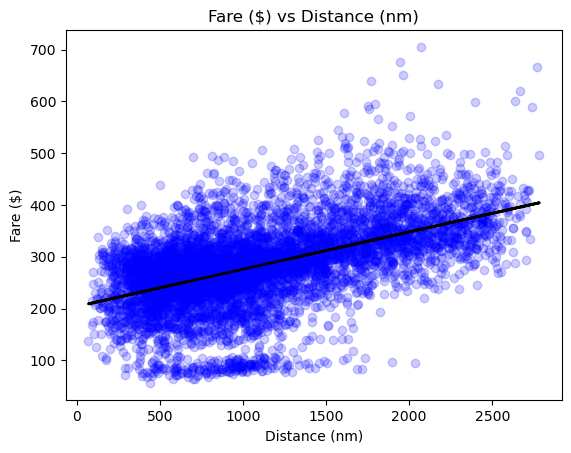

In [8]:
#linear regression on fare vs distance

x = all_pdew['nsmiles'].values    #predictor variable
y = all_pdew['fare'].values       #response variable

#we need to reshape the predictor variable from an array to a column vector
X = x.reshape(-1, 1)

model = linear_model.LinearRegression()
model.fit(X,y)

plt.scatter(X,y,color='blue',alpha=0.2)     
plt.plot(X,model.predict(X),color='black',linewidth='2')           #this plots the least squares regression line
plt.title('Fare ($) vs Distance (nm)')
plt.xlabel('Distance (nm)')
plt.ylabel('Fare ($)')

#let's get the r^2 value also
print(f'R^2 value: {model.score(X,y):.4}')

Text(0, 0.5, 'Fare ($)')

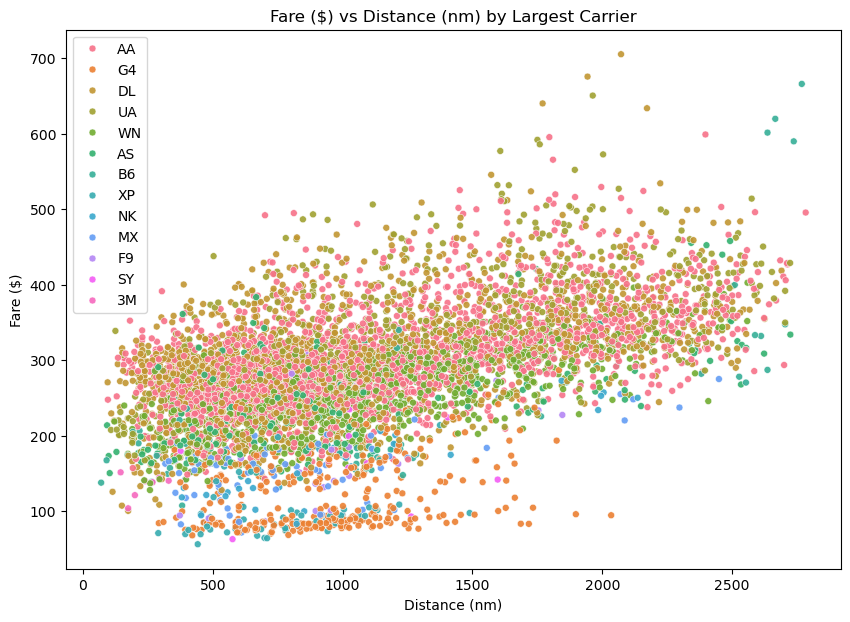

In [9]:
#we color code the scatter plot based on the categorical carrier_lg variable
fig,ax = plt.subplots(figsize = (10,7))
carriers = all_pdew['carrier_lg'].values
#seaborn requires us to flatten the carrier list to a one dimensional array, which we do with .ravel().
sns.scatterplot(x=X.ravel(),y=y,hue=carriers,alpha=0.9,s=25)

plt.title('Fare ($) vs Distance (nm) by Largest Carrier')
plt.legend(loc='upper left')
plt.xlabel('Distance (nm)')
plt.ylabel('Fare ($)')

In [7]:
#this better lets us visualize clear differences by carrier, with G4 and NK comprising most of the lowest avg fare (~$100) routes.
#now we plot the weighted average fare on routes where each carrier is the largest.

avg_fare_by_carrier = pd.DataFrame(all_pdew.groupby('carrier_lg',as_index=False).apply(
    lambda x: np.average(x['fare'], weights=x['passengers']),
    include_groups=False)
                                  )
                                         
avg_fare_by_carrier.columns = ['carrier_lg', 'avg_fare']
avg_fare_by_carrier = avg_fare_by_carrier.sort_values(by='avg_fare',ascending=False)
avg_fare_by_carrier

,carrier_lg,avg_fare
10,UA,260.035988
1,AA,251.367022
4,DL,237.032842
3,B6,228.383484
2,AS,225.692683
11,WN,207.661374
9,SY,194.433438
8,NK,173.390292
5,F9,170.635599
7,MX,166.728838


Text(0.5, 1.0, 'Average Fare in Dominant Markets by Carrier')

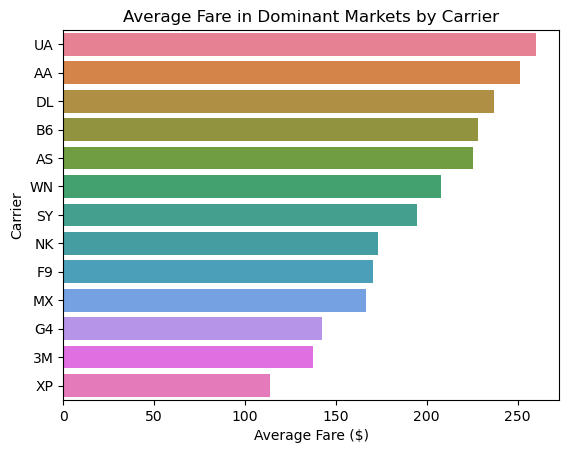

In [9]:
#now we plot this data
fig,ax=plt.subplots()
sns.barplot(data=avg_fare_by_carrier,x='avg_fare',y='carrier_lg',hue='carrier_lg')
plt.ylabel('Carrier')
plt.xlabel('Average Fare ($)')
plt.title('Average Fare in Dominant Markets by Carrier')

In [16]:
#unsurprisingly, city pairs dominated by the 3 legacy carriers have the highest average fares. 
#now, let's do the same to find the most expensive markets to fly in/out of. 

#first, see if there is any overlap in the city1 and city2 columns
np.isin(all_pdew['city1'].unique(),all_pdew['city2'].unique()).sum()

204

In [8]:
#thus, some cities are present in both columns, so we need to filter for both.
#to do this, we need to produce a dataframe that includes all individual cities in one column. This will contain twice as many rows.

df1 = all_pdew[['city1','passengers','fare','carrier_lg']].rename(columns={'city1':'city'})
df2 = all_pdew[['city2','passengers','fare','carrier_lg']].rename(columns={'city2':'city'})

df_merged = pd.concat([df1,df2],ignore_index=True)
df_merged

,city,passengers,fare,carrier_lg
0,"Allentown, PA",18,367.69,AA
1,"Allentown, PA",89,138.60,G4
2,"Allentown, PA",107,319.69,DL
3,"Allentown, PA",13,256.48,AA
4,"Allentown, PA",46,130.88,G4
...,...,...,...,...
13217,"Tulsa, OK",22,260.26,AA
13218,"Sanford, FL",139,82.52,G4
13219,"Springfield, MO",15,301.39,AA
13220,"Sarasota, FL",13,396.13,DL


In [9]:
#now we can weight by the individual cities the same way as before
avg_fare_by_city = pd.DataFrame(df_merged.groupby('city',as_index=False).apply(
    lambda x: np.average(x['fare'], weights=x['passengers']),
    include_groups=False)
    )

avg_fare_by_city.columns = ['city', 'avg_fare']
avg_fare_by_city = avg_fare_by_city.sort_values(by='avg_fare',ascending=False)
avg_fare_by_city.head(5)

,city,avg_fare
103,"Gunnison, CO",470.427258
10,"Aspen, CO",455.256127
53,"Cody, WY",444.065200
72,"Eagle, CO",442.986708
122,"Jackson, WY",434.503475


In [10]:
#unsurprisingly, the top 5 most expensive markets to fly in/out of are ski towns.
#now we can finally use the citymarket geodataframe to plot where the most and least expensive cities to fly in/out of are.
avg_fare_geo = avg_fare_by_city.merge(all_cities_geo, left_on = 'city', right_on = 'cityname').drop(columns='cityname')

In [11]:
usa_map = gpd.read_file('C:\\Users\\olubl\\OneDrive\\14th grade\\PDEW_Predict\\data\\usa_map.json')

In [12]:
#check that both are geodataframes
print(type(avg_fare_geo))
print(type(usa_map))

<class 'pandas.core.frame.DataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [12]:
#convert avg_fare_geo to gdf
avg_fare_gdf = gpd.GeoDataFrame(avg_fare_geo, geometry = 'geometry').set_crs(4326,inplace = True, allow_override = True)

In [18]:
avg_fare_gdf.geometry.is_valid.all()

True

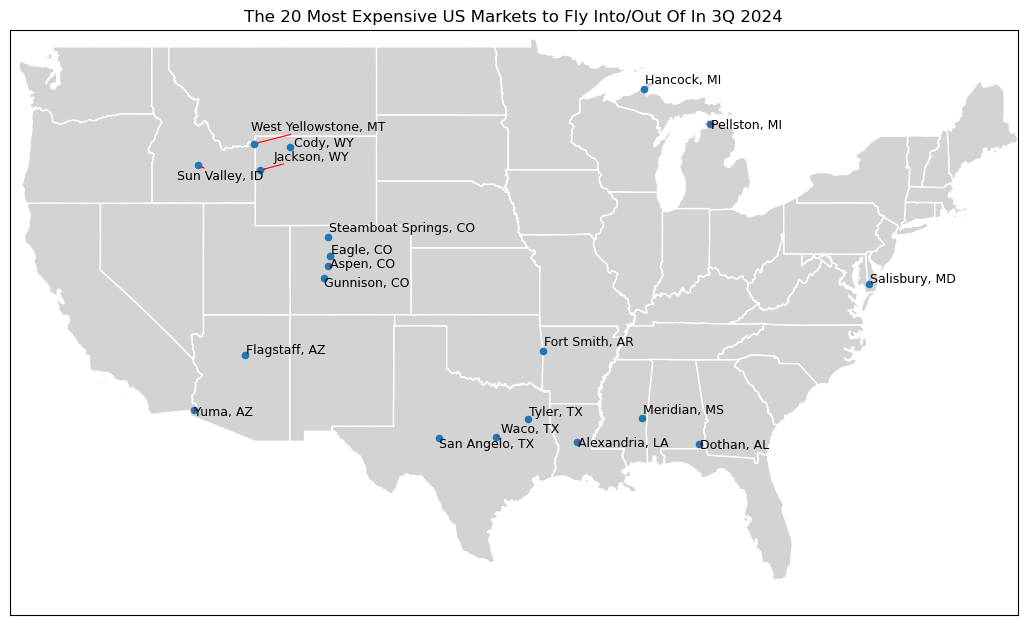

In [56]:
#plotting the 20 most expensive cities to fly into/out of
data = avg_fare_gdf.head(20)
fig, ax = plt.subplots(figsize = (13,16))

usa_map.plot(
    ax = ax,
    color = 'lightgrey',
    edgecolor = 'white')

data.plot(
    ax = plt.gca(),
    markersize = 20
)
bounds = avg_fare_gdf.total_bounds
ax.set_xlim(bounds[0]-1,bounds[2]+1)
ax.set_ylim(bounds[1]-1,bounds[3]+1)

ax.set_xticks([])
ax.set_yticks([])

#add labels for each citymarket. we can avoid overlap using adjustText.
texts = []
for x, y, cityname in zip(data['geometry'].x, data['geometry'].y, data['city']):        #zip lets us iterate over multiple iterables
    texts.append(ax.text(x,y,cityname,fontsize = 9))   #ax.text, unlike ax.annotate, simply assigns each string to its respective coords.
    
adjust_text(texts, expand = (1,1), arrowprops = dict(arrowstyle='->', color = 'red', lw = 0.8))     #texts is a list of matplotlib.text.Text objects, which is the primary parameter for adjust_text.


plt.title('The 20 Most Expensive US Markets to Fly Into/Out Of In 3Q 2024')
plt.show()

In [14]:
#using the same df_merged dataframe, we can produce a dataframe showing the percent of routes each carrier has the largest market share on out of each of the 274 markets in the dataframe

carriers = ['AA', 'G4', 'DL', 'UA', 'WN', 'AS', 'B6', 'XP', 'NK', 'MX', 'F9', 'SY', '3M']
city_matrix = pd.DataFrame(columns = ['city'] + carriers)      #the columns of this dataframe are the respective citymarkets and all carriers
for city in df_merged['city'].unique():
    pct_dict = {'city':city}
    for carrier in carriers:
        pct_dict[carrier] = round(sum(df_merged[df_merged['city']==city]['carrier_lg'] == carrier)/len(df_merged[df_merged['city']==city]),3)    #proportion of routes dominated by each carrier
        pct_df = pd.DataFrame([pct_dict])
    city_matrix = pd.concat([city_matrix, pct_df], ignore_index = True)

C:\Users\olubl\AppData\Local\Temp\ipykernel_16764\235179229.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  city_matrix = pd.concat([city_matrix, pct_df], ignore_index = True)


In [ ]:
#plot 20 busiest routes

In [15]:
city_matrix.head() #shows the proportion of routes from each citymarket dominated by each carrier

,city,AA,G4,DL,UA,WN,AS,B6,XP,NK,MX,F9,SY,3M
0,"Allentown, PA",0.318,0.455,0.182,0.045,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Abilene, TX",1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Albuquerque, NM",0.231,0.000,0.074,0.111,0.556,0.019,0.009,0.0,0.0,0.0,0.0,0.0,0.0
3,"Aberdeen, SD",0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Nantucket, MA",0.316,0.000,0.105,0.105,0.000,0.000,0.474,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#count the number of markets each carrier dominates in (has the greatest proportion of dominant routes)
only_carriers = city_matrix[carriers]
only_carriers.eq(only_carriers.max(axis=1), axis=0).sum()    #gets the carrier with proportion equal to greatest prop. of routes out of citymarket

AA    112
G4     22
DL     71
UA     37
WN     18
AS      8
B6      5
XP      5
NK      2
MX      4
F9      1
SY      2
3M      0
dtype: int64

In [19]:
#now we can plot the most dominant carrier in each market on the map
city_matrix['dominant_carrier'] = city_matrix.loc[:,city_matrix.columns != 'city'].idxmax(axis=1)     #returns the id (carrier) corresponding to the largest row value

In [20]:
city_matrix.head()

,city,AA,G4,DL,UA,WN,AS,B6,XP,NK,MX,F9,SY,3M,dominant_carrier
0,"Allentown, PA",0.318,0.455,0.182,0.045,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,G4
1,"Abilene, TX",1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,AA
2,"Albuquerque, NM",0.231,0.000,0.074,0.111,0.556,0.019,0.009,0.0,0.0,0.0,0.0,0.0,0.0,WN
3,"Aberdeen, SD",0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,DL
4,"Nantucket, MA",0.316,0.000,0.105,0.105,0.000,0.000,0.474,0.0,0.0,0.0,0.0,0.0,0.0,B6


In [34]:
city_matrix_geo = gpd.GeoDataFrame(city_matrix.merge(avg_fare_geo[['city','geometry']]))

Text(0.5, 1.0, 'Carrier With Greatest Proportion of Dominant Routes to/from Citymarket')

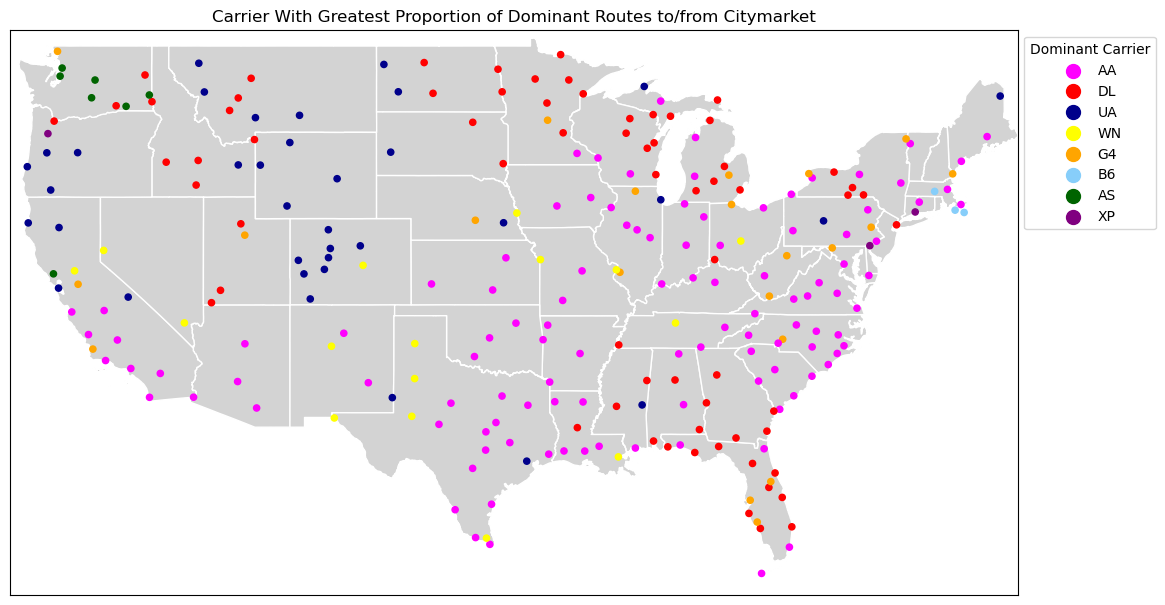

In [61]:
data = city_matrix_geo[city_matrix_geo['dominant_carrier'].isin(['AA','UA','DL','WN','G4','B6','AS','XP'])] #only points with at least 5 dominant markets

carrier_colors = {
    'AA': 'magenta',
    'DL': 'red',
    'UA': 'darkblue',
    'WN': 'yellow',
    'G4': 'orange',
    'B6': 'lightskyblue',
    'AS': 'darkgreen',
    'XP': 'purple' 
}

fig,ax = plt.subplots(figsize = (13,16))

usa_map.plot(
    ax = ax,
    color = 'lightgrey',
    edgecolor = 'white'
)

data.plot(
    ax = plt.gca(),
    markersize = 20,
    marker = 'o',
    color = data['dominant_carrier'].map(carrier_colors),    #setting the carrier-respective colormap
)

bounds = city_matrix_geo.total_bounds
ax.set_xlim(bounds[0]-1,bounds[2]+1)
ax.set_ylim(bounds[1]-1,bounds[3]+1)

ax.set_xticks([])
ax.set_yticks([])


for carrier, color in carrier_colors.items():
    ax.scatter([],[], color = color, label = carrier, s = 100)
ax.legend(title='Dominant Carrier', bbox_to_anchor = [1,1])

plt.title('Carrier With Greatest Proportion of Dominant Routes to/from Citymarket')

[]

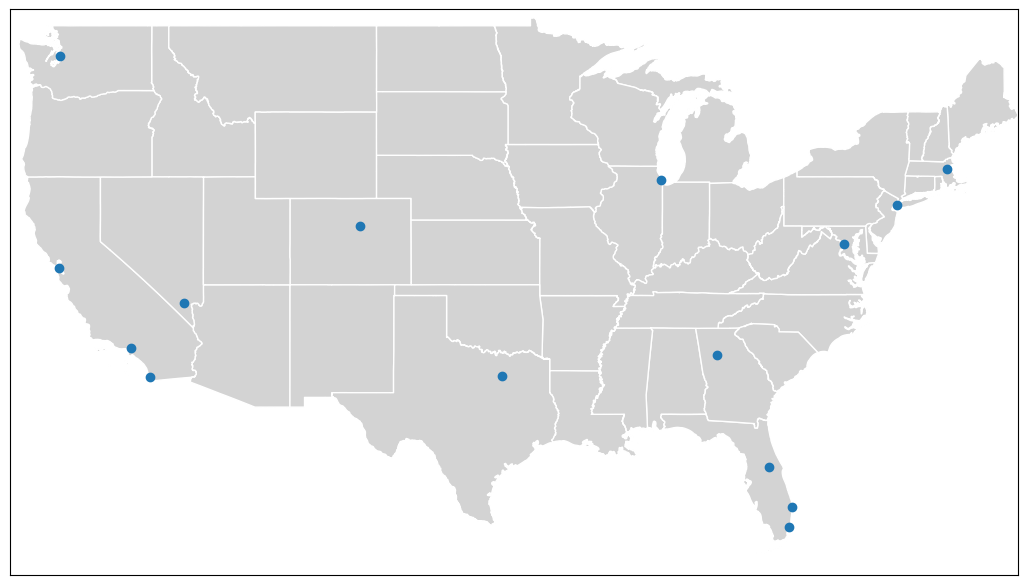

In [88]:
#plotting the 20 busiest citymarket pairs in 3q 2024
data = all_pdew.sort_values(by = 'passengers', ascending = False).head(20)

#need to get the geometries of all cities in here
cities_to_plot = pd.DataFrame(pd.unique(data[['city1','city2']].values.ravel()))
cities_to_plot.columns = ['city']     #cities_to_plot is now a dataframe containing all unique citymarkets in the top 20 citypairs
cities_geo = gpd.GeoDataFrame(cities_to_plot.merge(all_cities_geo, left_on = 'city', right_on = 'cityname'))

fig,ax = plt.subplots(figsize = (13,16))

usa_map.plot(
    ax = ax,
    color = 'lightgrey',
    edgecolor = 'white'
)

cities_geo.plot(
    ax = plt.gca(),
)

#now we need to connect the points in the top 20 
lines = []
for 
lines.append(LineString([city1,city2]))

bounds = city_matrix_geo.total_bounds
ax.set_xlim(bounds[0]-1,bounds[2]+1)
ax.set_ylim(bounds[1]-1,bounds[3]+1)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Top 20 City Pairs')

In [95]:
data[['city1','city2']]

,city1,city2
5043,"Los Angeles, CA","San Francisco, CA"
4956,"Miami, FL","New York City, NY"
5037,"Los Angeles, CA","New York City, NY"
4012,"New York City, NY","Orlando, FL"
2512,"Chicago, IL","New York City, NY"
884,"Atlanta, GA","New York City, NY"
4018,"New York City, NY","San Francisco, CA"
5024,"Los Angeles, CA","Seattle, WA"
2542,"Chicago, IL","Los Angeles, CA"
4667,"Las Vegas, NV","Los Angeles, CA"
